In [1]:
#basic packages
import numpy as np
import pandas as pd
import scipy
import pickle
import random
import os

# loading in and transforming data
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import PIL
from PIL import Image
import imageio

# visualizing data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from seed import set_seed
from mappingData import save_model, load_model
from ImageDataset import ImageDataset
from model import Discriminator, Generator
from show_test_file import show_test, reverse_normalize

In [2]:
set_seed()

In [3]:
dataset_monet = ImageDataset('Monet', img_size=256, normalize=True)
dataset_photo = ImageDataset('Photo', img_size=256, normalize=True)

In [4]:
batch_size_test = 8
batch_size=8
test_dataloader_Y = DataLoader(dataset_monet, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
test_dataloader_X = DataLoader(dataset_photo, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
dataloader_Y = DataLoader(dataset_monet, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
dataloader_X = DataLoader(dataset_photo, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

(518, 1034, 3)


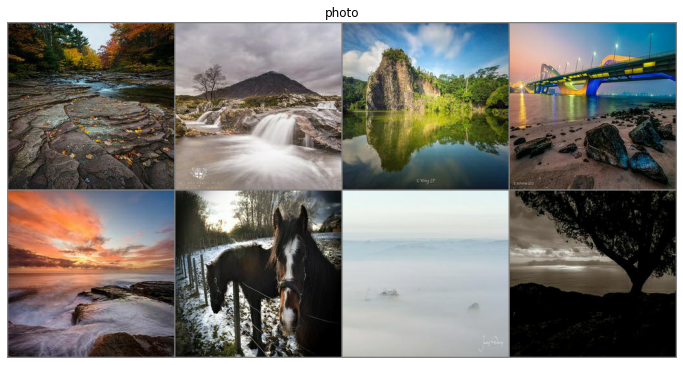

In [5]:
dataiter = iter(test_dataloader_X)
images_normalized = dataiter.next()
grid_normalized = make_grid(images_normalized, nrow=4).permute(1, 2, 0).detach().numpy()
print(grid_normalized.shape)
grid_original = reverse_normalize(grid_normalized)
fig = plt.figure(figsize=(12, 8))
plt.imshow(grid_original)
plt.axis('off')
plt.title('photo')
plt.show()

In [6]:
from torch.nn import init
def weights_init_normal(m):
    classname = m.__class__.__name__
    
    std_dev = 0.02
    mean = 0.0
    if hasattr(m, 'weight') and (classname.find('Conv') != -1):
        init.normal_(m.weight.data, mean, std_dev)

In [7]:
def build_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    
    G_XtoY = Generator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = Generator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)
    
    
    G_XtoY.apply(weights_init_normal)
    G_YtoX.apply(weights_init_normal)
    D_X.apply(weights_init_normal)
    D_Y.apply(weights_init_normal)
    
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('On GPU')
    else:
        print('On CPU')

    return G_XtoY, G_YtoX, D_X, D_Y

In [8]:
G_XtoY, G_YtoX, D_X, D_Y = build_model(n_res_blocks=6)

On GPU


In [9]:
dataiter = iter(dataloader_X)
images_normalized = dataiter.next()
imgs = images_normalized.to("cuda:0")

In [10]:
load_model(G_XtoY, G_YtoX, D_X, D_Y)

In [11]:
def real_mse_loss(D_out, adverserial_weight=1):
    mse_loss = torch.mean((D_out-1)**2)*adverserial_weight
    return mse_loss

def fake_mse_loss(D_out, adverserial_weight=1):
    mse_loss = torch.mean(D_out**2)*adverserial_weight
    return mse_loss

def cycle_consistency_loss(real_img, reconstructed_img, lambda_weight=1):
    reconstr_loss = torch.mean(torch.abs(real_img - reconstructed_img))
    return lambda_weight*reconstr_loss 

def identity_loss(real_img, generated_img, identity_weight=1):
    ident_loss = torch.mean(torch.abs(real_img - generated_img))
    return identity_weight*ident_loss

In [12]:
import torch.optim as optim

lr=0.0002
beta1=0.500
beta2=0.999
g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())

g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

In [13]:
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=1000):
    
    losses = []
    
    adverserial_weight = 0.5
    lambda_weight = 10
    identity_weight = 5
    
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)
    fixed_X = test_iter_X.next()
    fixed_Y = test_iter_Y.next()
    
    
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))
    
    d_total_loss_avg = 0.0
    g_total_loss_avg = 0.0
    
    for epoch in range(1, n_epochs+1):
        
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)
        
        images_X = iter_X.next()
        images_Y = iter_Y.next()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)
        
        
        d_x_optimizer.zero_grad()
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x, adverserial_weight)
        
        fake_X = G_YtoX(images_Y)
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x, adverserial_weight)
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()
        
        
        
        
        d_y_optimizer.zero_grad()
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y, adverserial_weight)
        
        fake_Y = G_XtoY(images_X)
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y, adverserial_weight)
        
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()
        
        
        
        d_total_loss = D_X_real_loss + D_X_fake_loss + D_Y_real_loss + D_Y_fake_loss
        

        
        
        
        g_optimizer.zero_grad()
        fake_X = G_YtoX(images_Y)
        out_x = D_X(fake_X)
        
        g_YtoX_loss = real_mse_loss(out_x, adverserial_weight)
        
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=lambda_weight)
        
        identity_y_loss = identity_loss(images_Y, fake_X, identity_weight=identity_weight)
        
        
        
        fake_Y = G_XtoY(images_X)
        
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y, adverserial_weight)

        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=lambda_weight)

        identity_x_loss = identity_loss(images_X, fake_Y, identity_weight=identity_weight)
        
        
        
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss + identity_y_loss + identity_x_loss
        g_total_loss.backward()
        g_optimizer.step()
        
        

        
         #avg_loss
        d_total_loss_avg = d_total_loss_avg + d_total_loss / batches_per_epoch
        g_total_loss_avg = g_total_loss_avg + g_total_loss / batches_per_epoch
        
        
        print_every = batches_per_epoch
        if epoch % print_every == 0:
            losses.append((d_total_loss_avg.item(), g_total_loss_avg.item()))
            true_epoch_n = int(epoch/batches_per_epoch)
            true_epoch_total = int(n_epochs/batches_per_epoch)
            print('Epoch [{:5d}/{:5d}] | d_total_loss_avg: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    true_epoch_n, true_epoch_total, d_total_loss_avg.item(), g_total_loss_avg.item()))
        
        show_every = (batches_per_epoch*1)
        if epoch % show_every == 0:
            G_YtoX.eval()
            G_XtoY.eval()
            test_images = show_test(fixed_Y, fixed_X, G_YtoX, G_XtoY)
            G_YtoX.train()
            G_XtoY.train()
        

        
        checkpoint_every=10
        if epoch % checkpoint_every == 0:
            save_model(G_XtoY, G_YtoX, D_X, D_Y)
    
    
        if epoch % batches_per_epoch == 0:
            d_total_loss_avg = 0.0
            g_total_loss_avg = 0.0
            
        
    
    return losses

In [14]:
batches_per_epoch = min(len(dataloader_X), len(dataloader_Y))
epoch_true = 100

Epoch [    1/    1] | d_total_loss_avg: 0.1616 | g_total_loss: 6.3135


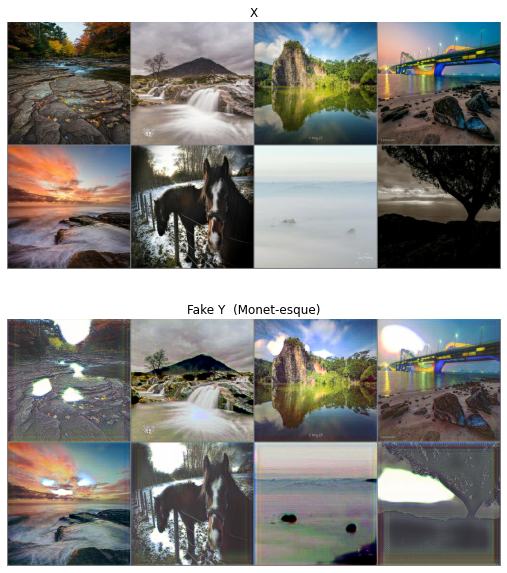

In [15]:
n_epochs = epoch_true * batches_per_epoch
losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

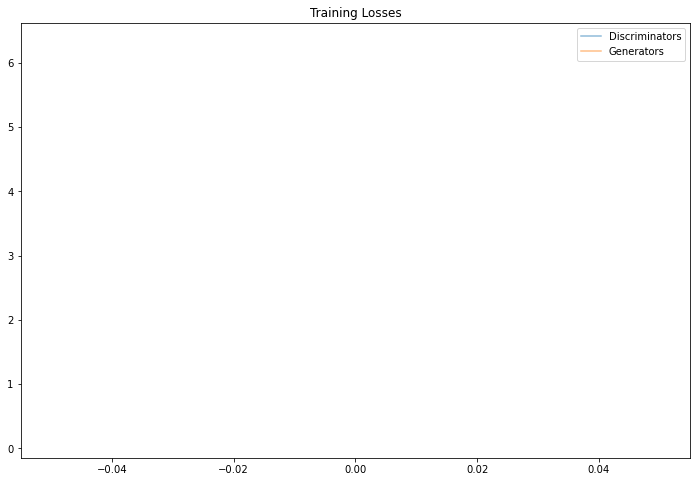

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminators', alpha=0.5)
plt.plot(losses.T[1], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()
plt.show()


In [ ]:
G_XtoY.eval()

submit_dataloader = DataLoader(dataset_photo, batch_size=1, shuffle=False, pin_memory=True)
dataiter = iter(submit_dataloader)

mean_=0.5 
std_=0.5

for image_idx in range(0, len(submit_dataloader)):
    fixed_X = dataiter.next()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    fake_Y = G_XtoY(fixed_X.to(device))
    fake_Y = fake_Y.detach().cpu().numpy()
    fake_Y = reverse_normalize(fake_Y, mean_, std_)
    fake_Y = fake_Y[0].transpose(1, 2, 0)
    fake_Y = np.uint8(fake_Y)
    fake_Y = Image.fromarray(fake_Y)
    
    fake_Y.save("../kaggle_gan/images/" + str(image_idx) + ".jpg")

G_XtoY.train()